In [17]:
from astropy.io import ascii
from scipy.optimize import minimize
from scipy import interpolate

import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Fourier function, Eq. 8 in the paper
def function_fourier_fit(a, t):
    
    ret = a[0] + a[1]*np.sin(2*np.pi*(t)) + a[2]*np.cos(2*np.pi*(t))
    i = 0

    for deg in range(3, len(a),2):
        i+=1
        ret += a[deg]*np.sin(2*(i+1)*np.pi*(t)) + a[deg+1]*np.cos(2*(i+1)*np.pi*(t))

    return ret


# Log-normal distribution
def ln_normal(dy, std):
    return -0.5 * (dy)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

# Data for a given star

In [19]:
# --------- example

time_of_brighness_maxima = 2455197.5 # M0
pulsation_period = 0.53 # per
ampV = 0.6   # amplitude in V-band
eampV = 0.01 # error on amplitude in V-band

class_star = "RRab"

time_of_observations = np.array([2455197.62, 2455197.642]) # JD
line_of_sight_velocity = np.array([-30.6, -27.22]) # vlos
uncertainty_line_of_sight_velocity = np.array([1.44, 2.32]) # evlos

## Amplitude scaling relation

In [20]:
# Equation 8 in the paper
scaling_relation_RRab = np.array([53, -152, 163])     

# Equation 10 in the paper
covariance_matrix_scaling_relation_RRab = np.array([[ 276., -471., 184.], 
                                                    [-471., 826., -333.], 
                                                    [ 184., -333., 142.]])


## Template and scatter in template

In [21]:
# Table 3 in the paper
template_fourier_rrab1 = np.array([0.0000, -0.2846, -0.2663, 
                                   -0.0424, -0.1558, 0.0231, 
                                   -0.0917, 0.0350, -0.0277, 
                                   0.0306, 0.0088])

template_fourier_rrab2 = np.array([0.0000, -0.3138, -0.3384, 
                                   -0.0513, -0.1276, 0.0192, 
                                   -0.0676, 0.0304, -0.0313, 
                                   0.0139, 0.0109]) 

template_fourier_rrab3 = np.array([0.0000, -0.3160, -0.3079, 
                                   -0.0786, -0.1341, 0.0213, 
                                   -0.0809, 0.0354, -0.0464, 
                                   0.0415, 0.0051]) 

# Table B4, first column in the table
phase_for_scatter_in_template = np.array([0.000, 0.025, 0.075, 0.125, 
                                          0.175, 0.225, 0.275, 0.325, 
                                          0.375, 0.425, 0.475, 0.525, 
                                          0.575, 0.625, 0.675, 0.725, 
                                          0.775, 0.825, 0.875, 0.925, 
                                          0.975, 1.000])  

# Table B4, second, third and fourth column in the table
scatter_in_template_rrab1 = np.array([0.010, 0.010, 0.004, 0.000, 0.000, 
                                      0.020, 0.022, 0.047, 0.056, 0.017, 
                                      0.033, 0.025, 0.000, 0.023, 0.006, 
                                      0.025, 0.050, 0.038, 0.003, 0.028, 
                                      0.058, 0.058])

scatter_in_template_rrab2 = np.array([0.080, 0.080, 0.092, 0.059, 
                                      0.080, 0.053, 0.068, 0.075, 
                                      0.070, 0.075, 0.059, 0.058, 
                                      0.080, 0.070, 0.064, 0.139, 
                                      0.115, 0.094, 0.141, 0.257, 
                                      0.065, 0.065])     

scatter_in_template_rrab3 = np.array([0.015, 0.015, 0.000, 0.021, 
                                      0.000, 0.035, 0.006, 0.096, 
                                      0.048, 0.000, 0.057, 0.009, 
                                      0.065, 0.049, 0.055, 0.023, 
                                      0.129, 0.000, 0.197, 0.009, 
                                      0.043, 0.043])      




# Spline function that interpolates the discrete scatter along the pulsation phase
f_spline_err_rrab1 = interpolate.interp1d(phase_for_scatter_in_template, scatter_in_template_rrab1, kind='linear')
f_spline_err_rrab2 = interpolate.interp1d(phase_for_scatter_in_template, scatter_in_template_rrab2, kind='linear')
f_spline_err_rrab3 = interpolate.interp1d(phase_for_scatter_in_template, scatter_in_template_rrab3, kind='linear')

In [22]:
vector = np.array([ampV**3, ampV**2, ampV])
derivative_vector = np.array([ampV**2, ampV, 1.0])
        
Amp_line_of_sight_vel = scaling_relation_RRab @ vector 
uncertainty_Amp_line_of_sight_vel = np.sqrt(vector @ covariance_matrix_scaling_relation_RRab @ vector.T 
                                                    + ((scaling_relation_RRab[:3] @ derivative_vector)**2)*(eampV**2) + 6.3**2)                                          
        
print(r"Predicted amplitude of the line of sight velocity and its error is: %.1f ± %.1f kms-1" %(Amp_line_of_sight_vel, 
                                                                                           uncertainty_Amp_line_of_sight_vel))

Predicted amplitude of the line of sight velocity and its error is: 54.5 ± 6.5 kms-1


In [27]:
def systematic_velocity_determ(param, HJD, measured_velocity, uncertainty_measured_velocity, 
                               P, M0, Alos, eAlos, template_fourier, f_spline_err):
    
    vsys = param

    # Equation 18 in paper
    phase_star = np.mod(HJD - M0, P) / P
    
    # Equation 16 in paper
    model_velocity = function_fourier_fit(template_fourier, phase_star)*Alos + vsys

    # Equation 17 in paper
    evel_fin = np.sqrt(uncertainty_measured_velocity**2 
                       + (f_spline_err(phase_star)*Alos)**2 
                       + (function_fourier_fit(template_fourier,phase_star)*eAlos)**2 )

    # Equation 15 in paper
    result = ln_normal(measured_velocity - model_velocity, evel_fin) 

    
    return np.nansum(result[np.isfinite(result)])




# Possibility for including some priors
def prior(param):
    # pick a prior
    return 0.0


def LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos, 
                    template_fourier, f_spline_err):
    
    lp = prior(param)
    
    rety = systematic_velocity_determ(param, HJD, measured_velocity, 
                                      uncertainty_measured_velocity, 
                                      P, M0, Alos, eAlos, template_fourier, 
                                      f_spline_err) 

    return lp + rety


def LOG_minus(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos, template_fourier, f_spline_err):
    return -LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos, template_fourier, f_spline_err)

## Using Scipy library

In [28]:
if (class_star == "RRab") and (pulsation_period < 0.55):
    p0 = np.array([-50.])

    
    res = minimize(LOG_minus, x0=p0, args=(time_of_observations, 
                                          line_of_sight_velocity, 
                                          uncertainty_line_of_sight_velocity, 
                                          pulsation_period, 
                                          time_of_brighness_maxima, 
                                          Amp_line_of_sight_vel, 
                                          uncertainty_Amp_line_of_sight_vel, 
                                          template_fourier_rrab1, 
                                          f_spline_err_rrab1), method='BFGS') #SLSQP


    print("Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %(res.x[0], np.sqrt(np.diag(res.hess_inv))[0]))

elif (class_star == "RRab") and (pulsation_period > 0.55) and (pulsation_period < 0.7):
    
    p0 = np.array([-50.])

    res = minimize(LOG_minus, x0=p0, args=(time_of_observations, 
                                          line_of_sight_velocity, 
                                          uncertainty_line_of_sight_velocity, 
                                          pulsation_period, 
                                          time_of_brighness_maxima, 
                                          Amp_line_of_sight_vel, 
                                          uncertainty_Amp_line_of_sight_vel, 
                                          template_fourier_rrab2, 
                                          f_spline_err_rrab2), method='BFGS') #SLSQP


    print("Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %(res.x[0], np.sqrt(np.diag(res.hess_inv))[0]))
elif (class_star == "RRab") and (pulsation_period > 0.7):
    
    p0 = np.array([-50.])

    res = minimize(LOG_minus, x0=p0, args=(time_of_observations, 
                                          line_of_sight_velocity, 
                                          uncertainty_line_of_sight_velocity, 
                                          pulsation_period, 
                                          time_of_brighness_maxima, 
                                          Amp_line_of_sight_vel, 
                                          uncertainty_Amp_line_of_sight_vel, 
                                          template_fourier_rrab3, 
                                          f_spline_err_rrab3), method='BFGS') #SLSQP


    print("Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %(res.x[0], np.sqrt(np.diag(res.hess_inv))[0]))




Determined systemic velocity and its uncertainty is: -20.5 ± 1.7 kms-1


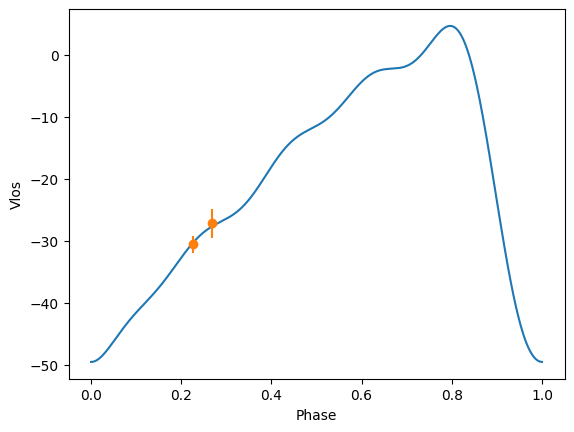

In [16]:
phase_star = np.mod(time_of_observations - time_of_brighness_maxima, pulsation_period) / pulsation_period

phase_star_model = np.linspace(0, 1, 1000)

model_velocity_rrab1 = function_fourier_fit(template_fourier_rrab1, phase_star_model)*Amp_line_of_sight_vel + res.x[0]

plt.plot(phase_star_model, model_velocity_rrab1)
plt.errorbar(phase_star, line_of_sight_velocity, yerr=uncertainty_line_of_sight_velocity, fmt="o")
plt.xlabel("Phase")
plt.ylabel("Vlos")
plt.show()